# Real-time $R_t$ computation on Piemonte COVID-19 data, by Stefano Terna$^1$

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Numero di riproduzione netto al tempo t, [Wikipedia](https://it.wikipedia.org/wiki/Numero_di_riproduzione_di_base#Numero_di_riproduzione_netto_al_tempo_t) 
4. FAQ sul calcolo del Rt, Istituto Superiore di Sanità, [link](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt)
5. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
6. Azienda sanitaria dell’Alto Adige, [Risultati](https://coronatest.sabes.it/it/muni) dello Screening a livello provinciale per il contenimento del Coronavirus
7. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 novembre 2020
8. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
9. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
10. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

In [2]:
import os
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan

BASE_DATA_PATH='../../data'
BASE_IMAGES_PATH='../../images'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# ISS Data

In [3]:
ISS_Rt = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/Rt_Piemonte_from_ISS.csv'),
    parse_dates=['computation_time_range_start', 'computation_time_range_end']
)

In [4]:
ISS_Rt_clean = ISS_Rt.loc[:,[
    'computation_time_range_start','computation_time_range_end','Rt','Rt_95_min','Rt_95_max'
]].dropna()

In [5]:
ISS_Rt_clean['Rt_95_err_max'] = ISS_Rt_clean.Rt_95_max - ISS_Rt_clean.Rt
ISS_Rt_clean['Rt_95_err_min'] = ISS_Rt_clean.Rt - ISS_Rt_clean.Rt_95_min

In [6]:
ISS_Rt_clean['Rt_reference_date'] = (
    (
        ISS_Rt_clean.computation_time_range_start + 
        (ISS_Rt_clean.computation_time_range_end - ISS_Rt_clean.computation_time_range_start)/2
    ).dt.normalize()+timedelta(days=1, minutes=-1)
)
ISS_Rt_clean.sort_values(by='Rt_reference_date', inplace=True)
ISS_Rt_clean.reset_index(inplace=True, drop=True)

In [7]:
ISS_Rt_clean.tail()

,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,Rt_95_err_max,Rt_95_err_min,Rt_reference_date
9,2021-01-27,2021-02-09,0.98,0.89,1.12,0.14,0.09,2021-02-02 23:59:00
10,2021-02-03,2021-02-16,1.03,0.92,1.18,0.15,0.11,2021-02-09 23:59:00
11,2021-02-10,2021-02-23,1.18,1.00,1.42,0.24,0.18,2021-02-16 23:59:00
12,2021-02-17,2021-03-02,1.31,1.12,1.47,0.16,0.19,2021-02-23 23:59:00
13,2021-02-24,2021-03-09,1.30,1.04,1.47,0.17,0.26,2021-03-02 23:59:00


# DPC Data

In [8]:
ALPHA = 100.
alpha = 1.87
beta = 0.28

In [9]:
def parse_date(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

regions_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv',
    parse_dates=['data'],
    date_parser=parse_date
)
# filter by date: (regions_raw_data.data<'2021-03-03')
#regional_raw_data = regions_raw_data.loc[(regions_raw_data.data<'2021-03-09') & (regions_raw_data.denominazione_regione=='Piemonte')].reset_index().copy()
regional_raw_data = regions_raw_data.loc[(True) & (regions_raw_data.denominazione_regione=='Piemonte')].reset_index().copy()

In [10]:
TIMESTEPS, _ = DPC.preprocess(regional_raw_data)
DPC.compute_first_diffs(regional_raw_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(regional_raw_data, regularizer)
DPC.bulk_compute_naive_Rt(regional_raw_data, alpha=alpha, beta = beta)

{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.999881413002743
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999820862156982
deceduti_giornalieri_smoothed - TIC R2: 0.9999896796260902
nuovi_positivi_smoothed - TIC R2: 0.9999898008443112
nuovi_casi_da_sospetto_diagnostico_smoothed - TIC R2: 0.9715261516965604
nuovi_casi_da_screening_smoothed - TIC R2: 0.9648688845269755
[   'nuovi_positivi',
 

In [11]:
DPC.RSVD_smooth_data(regional_raw_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)

['nuovi_positivi']
nuovi_positivi_deseason
info_cri:  -0.26648314603874174
info_cri:  1.315699552658358
TIC R2: 0.9732898572648827
patterns: 1
(   -9.738316540074706,
    8.630094378389544e-17,
    16,
    373,
    {   '1%': -3.448003816652923,
        '10%': -2.5709145866785503,
        '5%': -2.86931999731073},
    383.9717463601272)
new columns generated:
[   'nuovi_positivi_deseason',
    'nuovi_positivi_deseason_seasonality',
    'nuovi_positivi_deseason_smoothed',
    'nuovi_positivi_deseason_residuals',
    'nuovi_positivi_deseason_relative_residuals',
    'nuovi_positivi_deseason_smoothed_Rt']


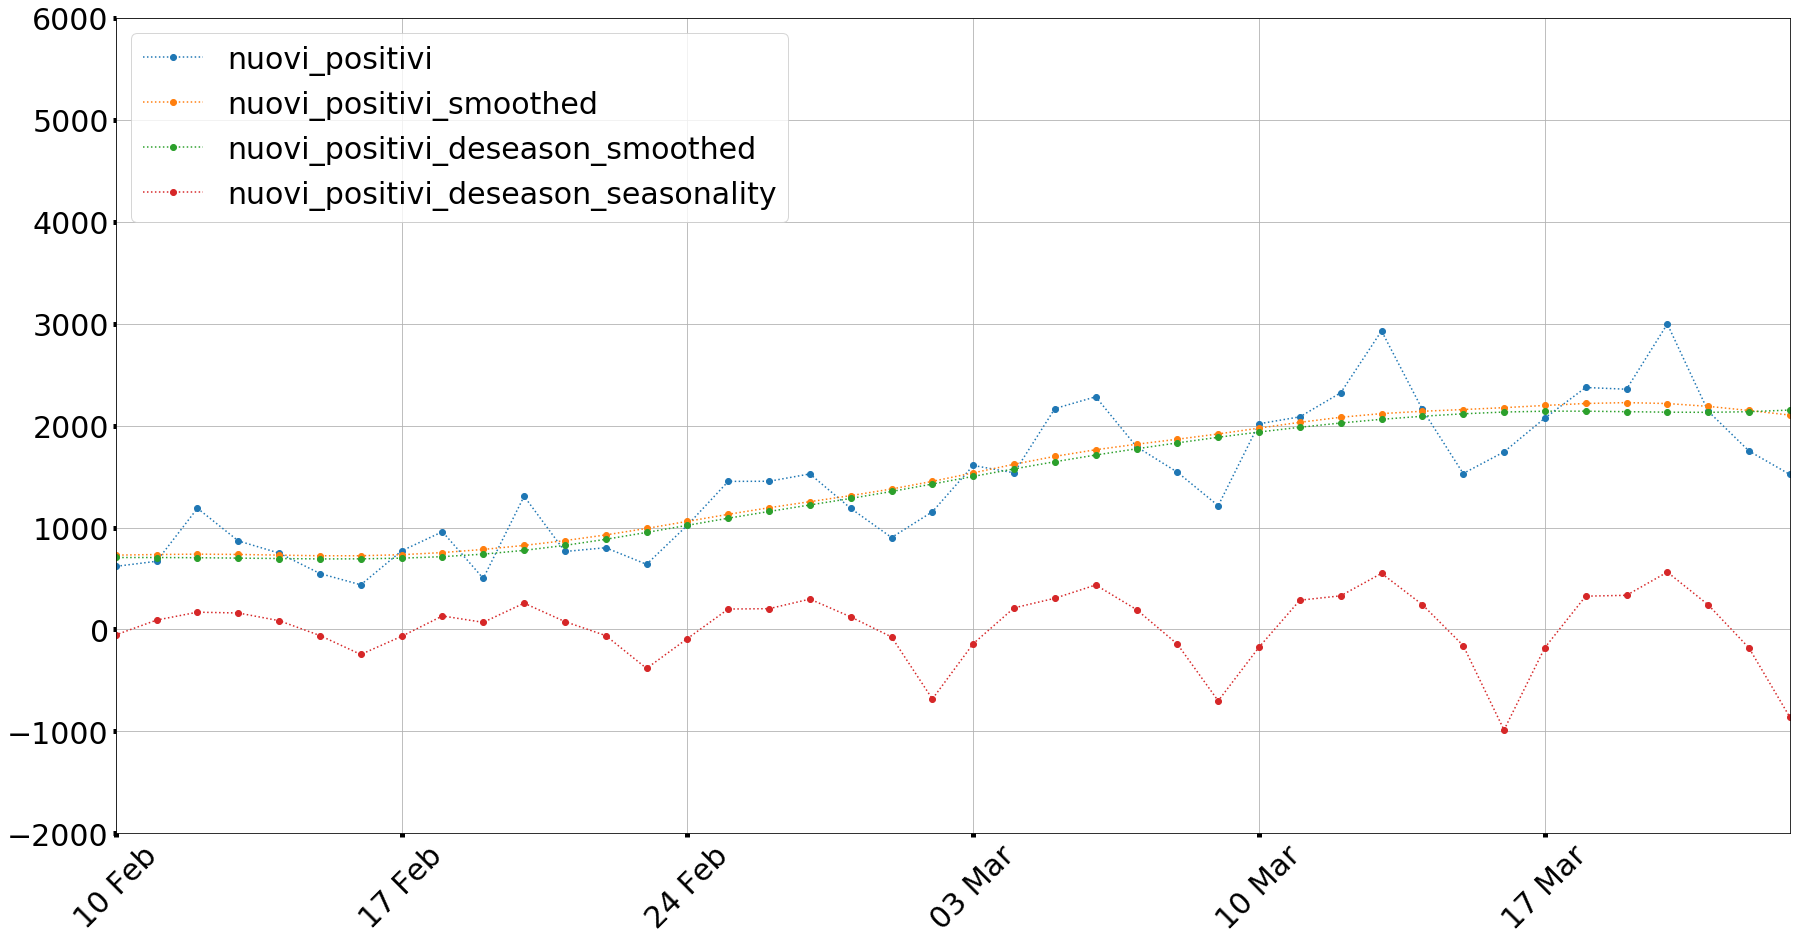

In [12]:
plotting.plot_series(
    df=regional_raw_data,
    xfield='data',
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed',
        'nuovi_positivi_deseason_seasonality'
    ],
    xlim=(datetime(2021,2,10), regional_raw_data.data.max()),
    ylim=(-2000,6000),
    legend_loc="upper left"
)

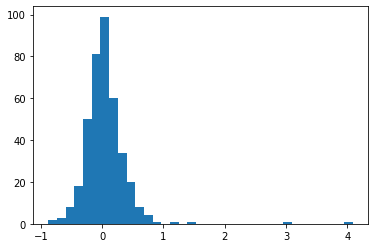

In [13]:
_=plt.hist(regional_raw_data.nuovi_positivi_deseason_relative_residuals,bins=35)

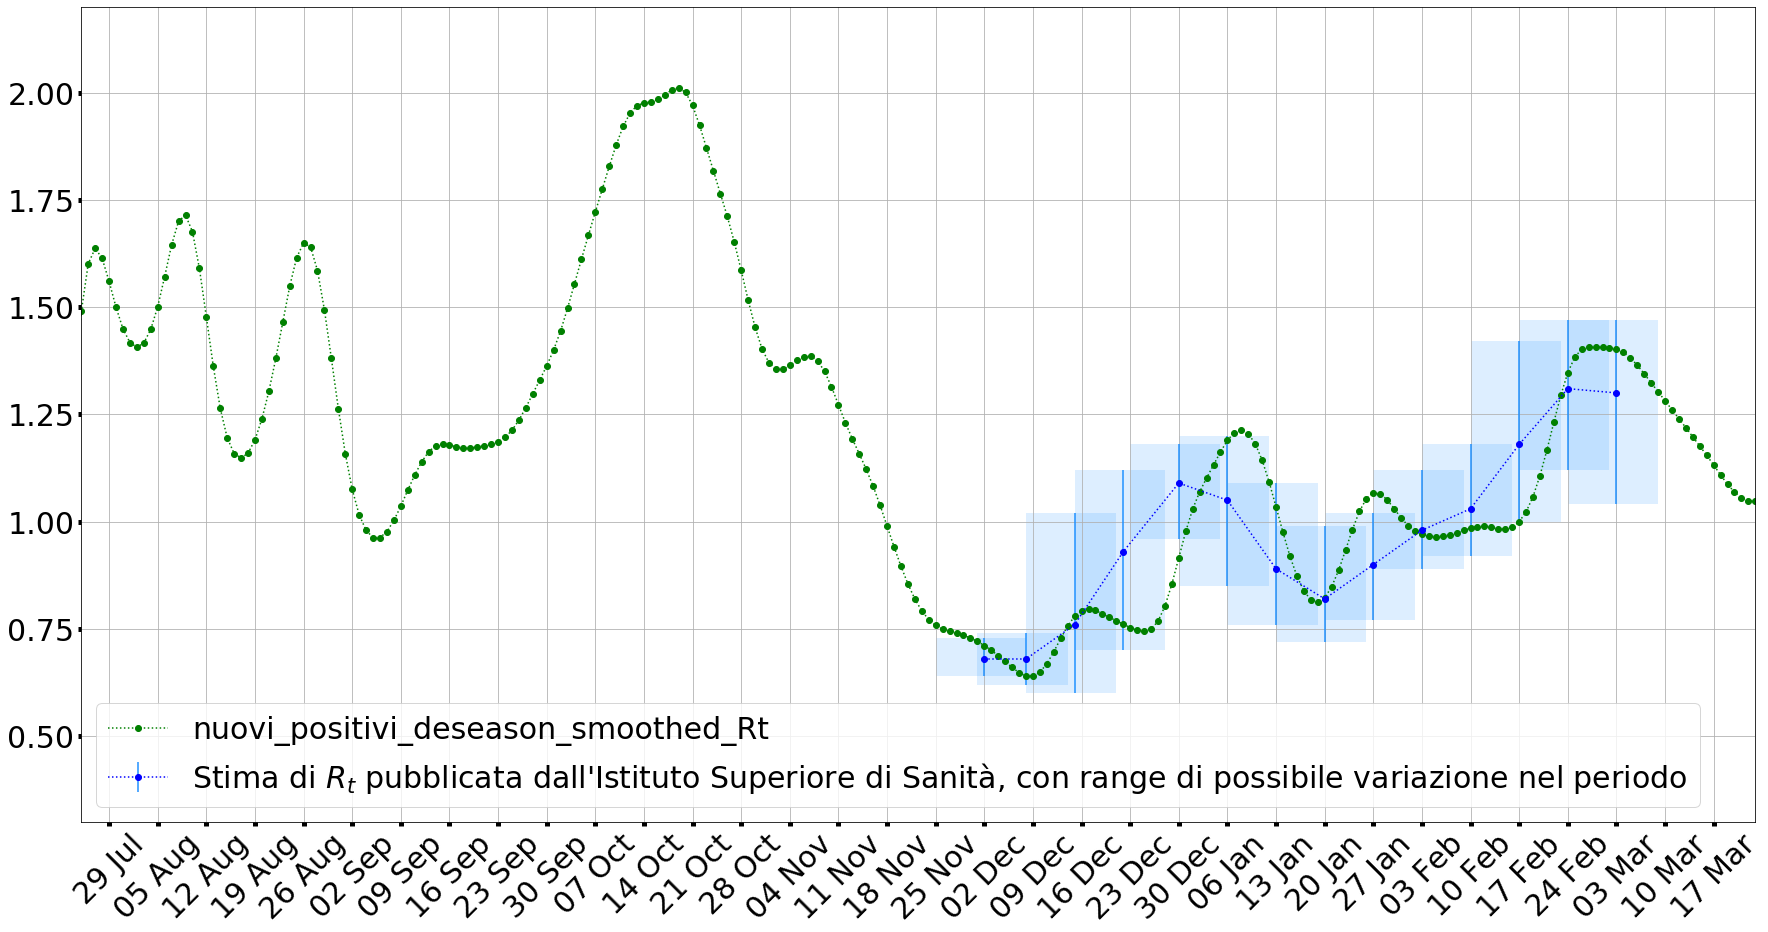

In [14]:
plotting.plot_series(
    data=[
        {
            'df':regional_raw_data,
            'xfield':'data',
            'yfields':[
                'nuovi_positivi_deseason_smoothed_Rt'
            ],
            'colors':['green']
        },
        {
            'df': ISS_Rt_clean,
            'xfield': 'Rt_reference_date',
            'yfields': ['Rt'],
            'bars': [['Rt_95_err_min','Rt_95_err_max']],
            'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
            'labels': ['Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
            'colors': ['blue']
        }        
    ],
    xlim=(datetime(2020,7,25), regional_raw_data.data.max()),
    ylim=(0.3,2.2),
    legend_loc="lower left",
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'UK_naive_Rt'),
    
)

# Calculation

The actual simulations run on virtual machines on IBM Cloud via the scripts contained in the `applications/` dir.

Here we just load the pickles generated by the simulations.

In [15]:
regional_calc_data = pd.read_pickle(os.path.join(BASE_DATA_PATH,'computed/italy/2021-03-22_futbound_08_12_Piemonte_MCMC_Rt_pastdays_000_000.pickle'))

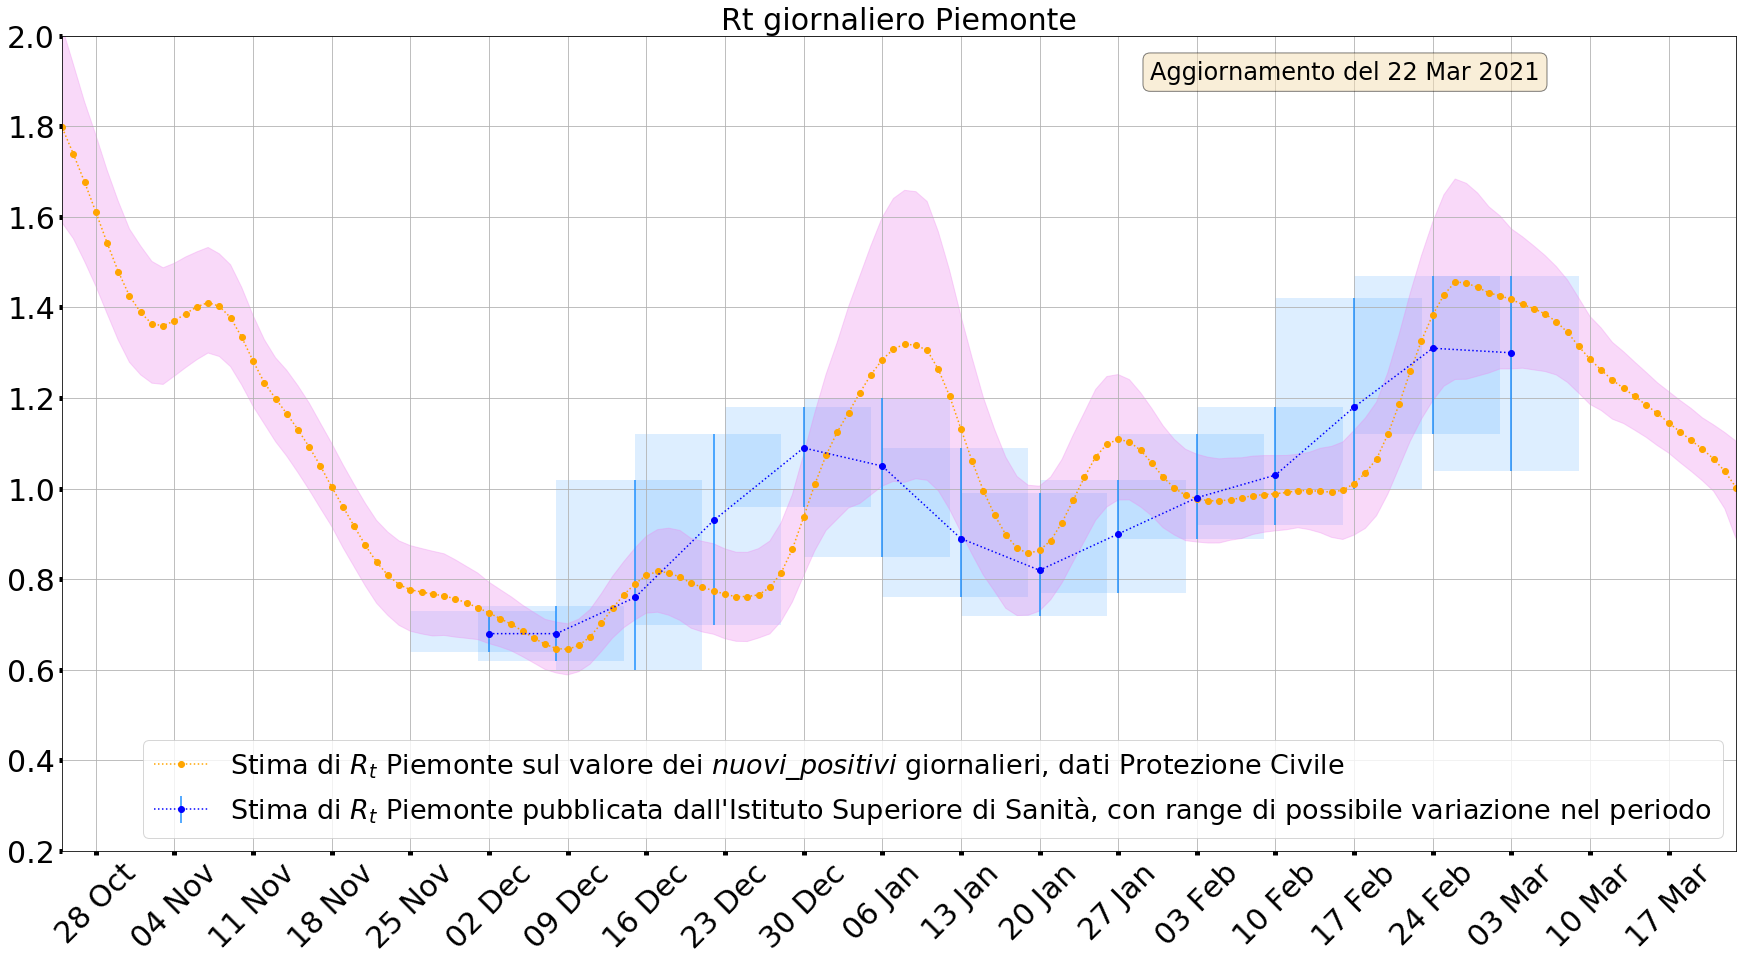

In [16]:
plotting.plot_series(
    title='Rt giornaliero Piemonte',
    message='Aggiornamento del {}'.format(regional_calc_data.data.max().strftime('%d %b %Y')),
    data=[
        {
            'df': ISS_Rt_clean,
            'xfield': 'Rt_reference_date',
            'yfields': ['Rt'],
            'bars': [['Rt_95_err_min','Rt_95_err_max']],
            'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
            'labels': ['Stima di $R_t$ Piemonte pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
            'colors': ['blue']
        },        
        {
            'df': regional_calc_data,
            'xfield': 'data',
            'yfields': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000', 
            ],
            'fill_between': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000',
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000',
            ],
            'labels': [
                f'Stima di $R_t$ Piemonte sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
            ],
            'colors':['orange']
        },
    ],
    legend_fontsize=27,
    xlim=(datetime(2020,10,25), regional_calc_data.data.max()),
    ylim=(0.2,2),
    legend_loc='lower right',
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, 'italy/regional_Piemonte_20210322_TD_Rt_computation_MCMC_150dpi'),
    dpi=150,
    quality=60
)

In [17]:
regional_calc_data.tail()

,index,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,...,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2,nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000
388,8161,2021-03-18 23:59:00,ITA,1,Piemonte,45.073274,7.680687,3279,315,3594,...,NaN,271435.0,10591.0,2250049.0,743446.0,ITC,ITC1,1.106812,1.038403,1.177245
389,8182,2021-03-19 23:59:00,ITA,1,Piemonte,45.073274,7.680687,3332,326,3658,...,NaN,274109.0,10914.0,2264029.0,763618.0,ITC,ITC1,1.087592,1.017599,1.156565
390,8203,2021-03-20 23:59:00,ITA,1,Piemonte,45.073274,7.680687,3361,332,3693,...,NaN,275852.0,11312.0,2274627.0,784037.0,ITC,ITC1,1.065798,0.994465,1.140900
391,8224,2021-03-21 23:59:00,ITA,1,Piemonte,45.073274,7.680687,3455,346,3801,...,NaN,277457.0,11458.0,2283026.0,791191.0,ITC,ITC1,1.038369,0.955639,1.123977
392,8245,2021-03-22 23:59:00,ITA,1,Piemonte,45.073274,7.680687,3536,349,3885,...,NaN,278833.0,11603.0,2291088.0,798414.0,ITC,ITC1,1.002510,0.889693,1.104876
